# 1. DATA CLEANING

## 1.1 - Loading the Data

In [1]:
import numpy as np
import pandas as pd

# List all files under the input directory:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/egypt-house-prices/egypt_House_prices.csv
/kaggle/input/clean-house-prices/cleaned_egy_house_prices.csv


In [2]:
df = pd.read_csv("/kaggle/input/egypt-house-prices/egypt_House_prices.csv")
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
df.head()

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,City
0,Duplex,4000000,3.0,3.0,400.0,No,7,Unknown,Cash,Ready to move,Finished,Nasr City
1,Apartment,4000000,3.0,3.0,160.0,No,10+,Unknown,Cash,Ready to move,Finished,Camp Caesar
2,Apartment,2250000,3.0,2.0,165.0,No,1,Unknown,Cash,Ready to move,Finished,Smoha
3,Apartment,1900000,3.0,2.0,230.0,No,10,Unknown,Cash,Ready to move,Finished,Nasr City
4,Apartment,5800000,2.0,3.0,160.0,No,Ground,Eastown,Cash,Ready to move,Semi Finished,New Cairo - El Tagamoa


In [3]:
df.shape

(27361, 12)

## 1.2 - Data Types & Formatting:

In [4]:
df.dtypes

Type              object
Price             object
Bedrooms          object
Bathrooms         object
Area              object
Furnished         object
Level             object
Compound          object
Payment_Option    object
Delivery_Date     object
Delivery_Term     object
City              object
dtype: object

- Price --> int
- Bedrooms --> int
- Bathrooms --> int
- Area --> float
- *Others are all fine as strings **for now***

'Unknown' & NaN values from numeric features must be removed first:

In [5]:
df.isnull().sum()

Type                0
Price               2
Bedrooms          203
Bathrooms         171
Area              471
Furnished           0
Level               0
Compound            0
Payment_Option      0
Delivery_Date       0
Delivery_Term       0
City                0
dtype: int64

In [6]:
numeric_features = ['Price', 'Bedrooms', 'Bathrooms', 'Area']
for feature in numeric_features:
    df = df[df[feature]!='Unknown']

df.shape

(27324, 12)

In [7]:
for feature in numeric_features:
    df = df[df[feature]!='Unknown']

df.dropna(inplace=True)

df.shape

(26693, 12)

Convert series numeric using pd.to_numeric(). However, observation '10+' in Bedrooms & Bathrooms is causing a problem:

There is one observation with 10+ bedrooms & 10+ bathrooms, so this single observation can be removed:

In [8]:
i = df[df['Bedrooms']=='10+'].index
df.drop(i, inplace=True)

for feature in numeric_features:
    df[feature] = pd.to_numeric(df[feature])
df.dtypes

Type               object
Price               int64
Bedrooms          float64
Bathrooms         float64
Area              float64
Furnished          object
Level              object
Compound           object
Payment_Option     object
Delivery_Date      object
Delivery_Term      object
City               object
dtype: object

Bedrooms & Bathrooms may be converted to int, just for good measure:

In [9]:
df = df.astype({'Bedrooms': int, 'Bathrooms':int})
df.dtypes

Type               object
Price               int64
Bedrooms            int64
Bathrooms           int64
Area              float64
Furnished          object
Level              object
Compound           object
Payment_Option     object
Delivery_Date      object
Delivery_Term      object
City               object
dtype: object

## 1.3 - Exploring Duplicates

In [10]:
df.duplicated().value_counts()

False    24809
True      1883
Name: count, dtype: int64

In [11]:
df.drop_duplicates(keep='first', inplace=True)
df.shape

(24809, 12)

## 1.4 - Inspecting Each Categorical Variable Individually

### Inspecting 'Type' Variable:

In [12]:
df['Type'].value_counts()

Type
Apartment            8030
Chalet               5955
Stand Alone Villa    3775
Town House           2835
Twin House           1657
Duplex                813
Standalone Villa      559
Penthouse             503
Twin house            457
Studio                225
Name: count, dtype: int64

Standalone villa, Twin house are recorded in two different ways. They should be combined using the .replace() method:

In [13]:
df.replace('Standalone Villa', 'Stand Alone Villa', inplace=True)
df.replace('Twin house', 'Twin House', inplace=True)
df['Type'].value_counts()

Type
Apartment            8030
Chalet               5955
Stand Alone Villa    4334
Town House           2835
Twin House           2114
Duplex                813
Penthouse             503
Studio                225
Name: count, dtype: int64

### Inspecting 'Furnished' Variable:

In [14]:
df['Furnished'].value_counts()

Furnished
No         15012
Unknown     7689
Yes         2108
Name: count, dtype: int64

**'Unknown' values here may be mapped to 'No' if used as a feature, to use this as a binary variable**

In [15]:
df['Furnished'].replace(['No', 'Unknown'], 'No', inplace=True)

### Inspecting 'Level' Variable:

In [16]:
df['Level'].value_counts()

Level
Unknown    9109
Ground     4335
2          3504
1          3321
3          1981
4           858
5           523
10+         254
6           217
7           206
Highest     169
8           126
10          103
9           103
Name: count, dtype: int64

**Initial assumption: 'Ground' will be the main level that affects price, others will be roughly the same.** This feature may be ordinally encoded at a later stage

### Inspecting 'Compound' Variable:

In [17]:
df['Compound'].value_counts()

Compound
Unknown                      10083
Madinaty                      1042
Mountain View North Coast      722
Hyde Park New Cairo            441
Rehab City                     405
                             ...  
Venus                            1
Assiut University                1
Golden Coast Sokhna              1
Amoun                            1
Selena                           1
Name: count, Length: 555, dtype: int64

**Due to too many categories and several compound values being 'No' this feature can be transformed to be binary (i.e. whether or not a property is part of a compound or not)**

In [18]:
df['Compound'] = df['Compound'].apply(lambda x: 'No' if x=='Unknown' else 'Yes')
df['Compound'].value_counts()

Compound
Yes    14726
No     10083
Name: count, dtype: int64

### Inspecting 'Payment Option' Variable:

In [19]:
df['Payment_Option'].value_counts()

Payment_Option
Cash or Installment    9810
Cash                   8566
Installment            3633
Unknown Payment        2800
Name: count, dtype: int64

**Initial Assumption: Cash + Installment usually most pricey (facility), 'Cash' payments are usually discounted.
So this feature likely has an effect in this manner**

Also, convert 'Unknown Payment' to 'Unknown' for consistency across all variables:

In [20]:
df['Payment_Option'].replace('Unknown Payment', 'Unknown', inplace=True)
df['Payment_Option'].value_counts()

Payment_Option
Cash or Installment    9810
Cash                   8566
Installment            3633
Unknown                2800
Name: count, dtype: int64

### Inspecting 'Delivery_Date' Variable:

In [21]:
df['Delivery_Date'].value_counts()

Delivery_Date
Ready to move      10952
Unknown             9035
soon                1541
2024                1002
2025                 962
2023                 653
2026                 360
within 6 months      176
2022                 124
2027                   4
Name: count, dtype: int64

***Due to no present metadata associated with this dataset, it is unclear when this dataset was curated. So one cannot fully take readings such as 'within 6 months' relative to any particular date***

*Operating under the assumption that this dataset appears to have data on houses from early January, categories will be transformed relative to the date: January 1st 2022*

'within 6 months' can be treated as 'ready to move' and 'Unknown' will be treated as 'not ready to move'

***The main difference will be observed when comparing 'Ready to Move' to any other category.*** So this feature can be transformed to whether or not the property is ready to move:

In [22]:
df['Delivery_Date'] = df['Delivery_Date'].apply(lambda x: 'Ready to Move' if x in ['Ready to move', 'within 6 months'] else 'Not ready to Move')
df['Delivery_Date'].value_counts()

Delivery_Date
Not ready to Move    13681
Ready to Move        11128
Name: count, dtype: int64

### Inspecting 'Delivery_Term' Variable:

In [23]:
df['Delivery_Term'].value_counts()

Delivery_Term
Finished         12997
Semi Finished     4956
Unknown           4352
Not Finished      1626
Core & Shell       878
Name: count, dtype: int64

*Property is delivered with this condition*

**Initial Assumption: This will definitely make a difference** ('Core & Shell' & 'Semi-Finished' & 'Not Finsihed' can be treated as one)

In [24]:
df.replace(['Not Finished', 'Core & Shell', 'Semi Finished'], 'Not Finished', inplace=True)

df['Delivery_Term'].value_counts()

Delivery_Term
Finished        12997
Not Finished     7460
Unknown          4352
Name: count, dtype: int64

### Inspecting 'City' Variable:

In [25]:
df['City'].value_counts()

City
New Cairo - El Tagamoa    6130
North Coast               5736
Sheikh Zayed              2074
6th of October            1600
Ain Sukhna                1559
                          ... 
New Beni Suef                1
Kafr al-Dawwar               1
Khanka                       1
Quesna                       1
Abu Rawash                   1
Name: count, Length: 178, dtype: int64

'View Phone Number' was an observed category in the 'City' column. ~50 observations so these observations can be removed altogether:

In [26]:
df = df[df['City']!= '(View phone number)']
df.shape

(24759, 12)

Checking for any other unknowns:

In [27]:
'Unknown' in df['City'].value_counts().index

False

#### Too many cities, so a 'Region' feature may be used instead:

In [28]:
region_map = {
    'New Cairo': ['New Cairo - El Tagamoa', 'Rehab City', 'Katameya', 'Madinaty', 'Nakheel', 'New Helioplis'],
    'Cairo': ['Nasr City', 'Mokattam', 'Heliopolis', 'Maadi', 'Dokki', 'Mohandessin', 'Zamalek', 'Garden City', 'Downtown Cairo', 'Zahraa Al Maadi', 'Sheraton', 'New Heliopolis', 'Gesr Al Suez', 'Helmeyat El Zaytoun', 'Ain Shams', 'Dar al-Salaam', 'Sayeda Zeinab', 'Matareya', 'El Fostat', 'Shubra', 'New Nozha', 'Helwan', 'Almazah', 'Abasiya', 'Shubra al-Khaimah', 'Masr al-Kadema', 'Hadayek al-Kobba', 'Ramses + Ramses Extension', 'Al Manial', 'Rod al-Farag', 'Boulaq', 'Al Amiriyyah', 'Tura', 'Ataba', 'Zawya al-Hamra', 'Darb al-Ahmar', 'Qasr al-Nil', 'Hadayek Helwan', 'Sharabeya'],
    'Giza and Suburbs': ['Sheikh Zayed', '6th of October', 'Hadayek al-Ahram', 'Faisal', 'Haram', 'West Somid', 'Hadayek 6th of October', 'Agouza', 'Imbaba', 'Warraq', 'Giza District', 'Boulaq Dakrour', 'Ezbet El Nakhl', 'Tersa', 'Maryotaya', 'Kit Kat', 'Ganoub District', 'Faisal District', 'Abu Rawash', 'Ard El Lewa', 'Markaz al-Giza', 'Saft El Laban'],
    'North Coast': ['North Coast', 'Alamein', 'Marsa Matrouh', 'Sidi Beshr', 'Borg al-Arab', 'Agami', 'Ras al-Bar', 'Dabaa', 'Amreya'],
    'Red Sea': ['Ain Sukhna', 'Hurghada', 'Gouna', 'Sahl Hasheesh', 'Ras Sedr', 'Safaga', 'Sharm al-Sheikh', 'Hammam'],
    'Delta Region': ['Mansura', 'Tanta', 'Zagazig', 'Damietta City', 'Gamasa', 'Mahalla al-Kobra', 'Sharq District', 'Kafr al-Sheikh City', 'Damanhour', 'Mit Ghamr', 'Shebin al-Koum', 'New Damietta', 'Banha', 'New Mansoura', 'Qalyub', 'Bella', 'Qanater al-Khairia', 'Aga', 'Khosous', 'Kafr al-Dawwar', 'Talkha', 'Khanka', 'Manzala', 'Quesna', 'Kafr Shukr'],
    'Suez Canal Cities': ['Suez', 'Port Said', 'Ismailia', 'Suez District', 'Ismailia City', 'Port Fouad', 'Fayed', 'Manakh District', 'Arab District', 'Zohour District', 'Arbaeen', 'Attaka', 'Dawahy District'],
    'Upper Egypt': ['Aswan City', 'Luxor', 'Minya', 'Qena', 'Sohag', 'Asyut City', 'New Minya', 'Minya City', 'Qena City', 'Beni Suef City', 'Minya al-Qamh', 'New Beni Suef', 'Markaz Sohag'],
    'Alexandria': ['Smoha', 'Miami', 'Moharam Bik', 'Stanley', 'Cleopatra', 'Sporting', 'San Stefano', 'Camp Caesar', 'Laurent', 'Mandara', 'Glim', 'Abu Talat', 'Bolkly', 'Al Ibrahimiyyah', 'Fleming', 'Azarita', 'Sidi Gaber', 'Kafr Abdo', 'Montazah', 'Seyouf', 'Asafra', 'Gianaclis', 'Saba Pasha', 'Roushdy', 'Zezenia', 'Maamoura', 'Abu Qir', 'Bahray - Anfoshy', 'Victoria', 'Manshiyya', 'Bacchus', 'Al Hadrah', 'Raml Station', 'Shatby', 'Kabbary', 'Schutz', 'Dhahria', 'Awayed', 'Gomrok', 'Attarin', 'El Max'],
    'New Cities': ['New Capital City', 'Mostakbal City', '10th of Ramadan', '15 May City', 'Badr City', 'Obour City', 'Shorouk City', 'Salam City', 'Sadat']
}

def map_region(city):
    for region, cities in region_map.items():
        if city in cities:
            return region
    return 'Other'

df['Region'] = df['City'].apply(map_region)

In [29]:
df['Region'].value_counts()

Region
New Cairo            8271
North Coast          6311
Giza and Suburbs     4148
New Cities           2063
Red Sea              1902
Cairo                1237
Alexandria            539
Delta Region          196
Suez Canal Cities      51
Upper Egypt            41
Name: count, dtype: int64

'City' column can now be removed:

In [30]:
df.drop(index=1, columns=['City'], inplace=True)
df.shape

(24758, 12)

#### Trying to remove all 'Unknown's:

In [31]:
df_wo_unknown = df

categorical_features = ['Type', 'Furnished', 'Level', 'Payment_Option', 'Delivery_Date', 'Delivery_Term', 'Compound', 'Region']

for feature in categorical_features:
    df_wo_unknown = df_wo_unknown[df_wo_unknown[feature]!='Unknown']
    print(df_wo_unknown.shape)

(24758, 12)
(24758, 12)
(15690, 12)
(14127, 12)
(14127, 12)
(14127, 12)
(14127, 12)
(14127, 12)


*A dataset without any unknown values will contain 14127 observations*

**Perhaps after EDA & Feature Selection consider removing Unknowns in selected columns only**

#### Removing outliers found in EDA (to export fully cleaned data at this stage):

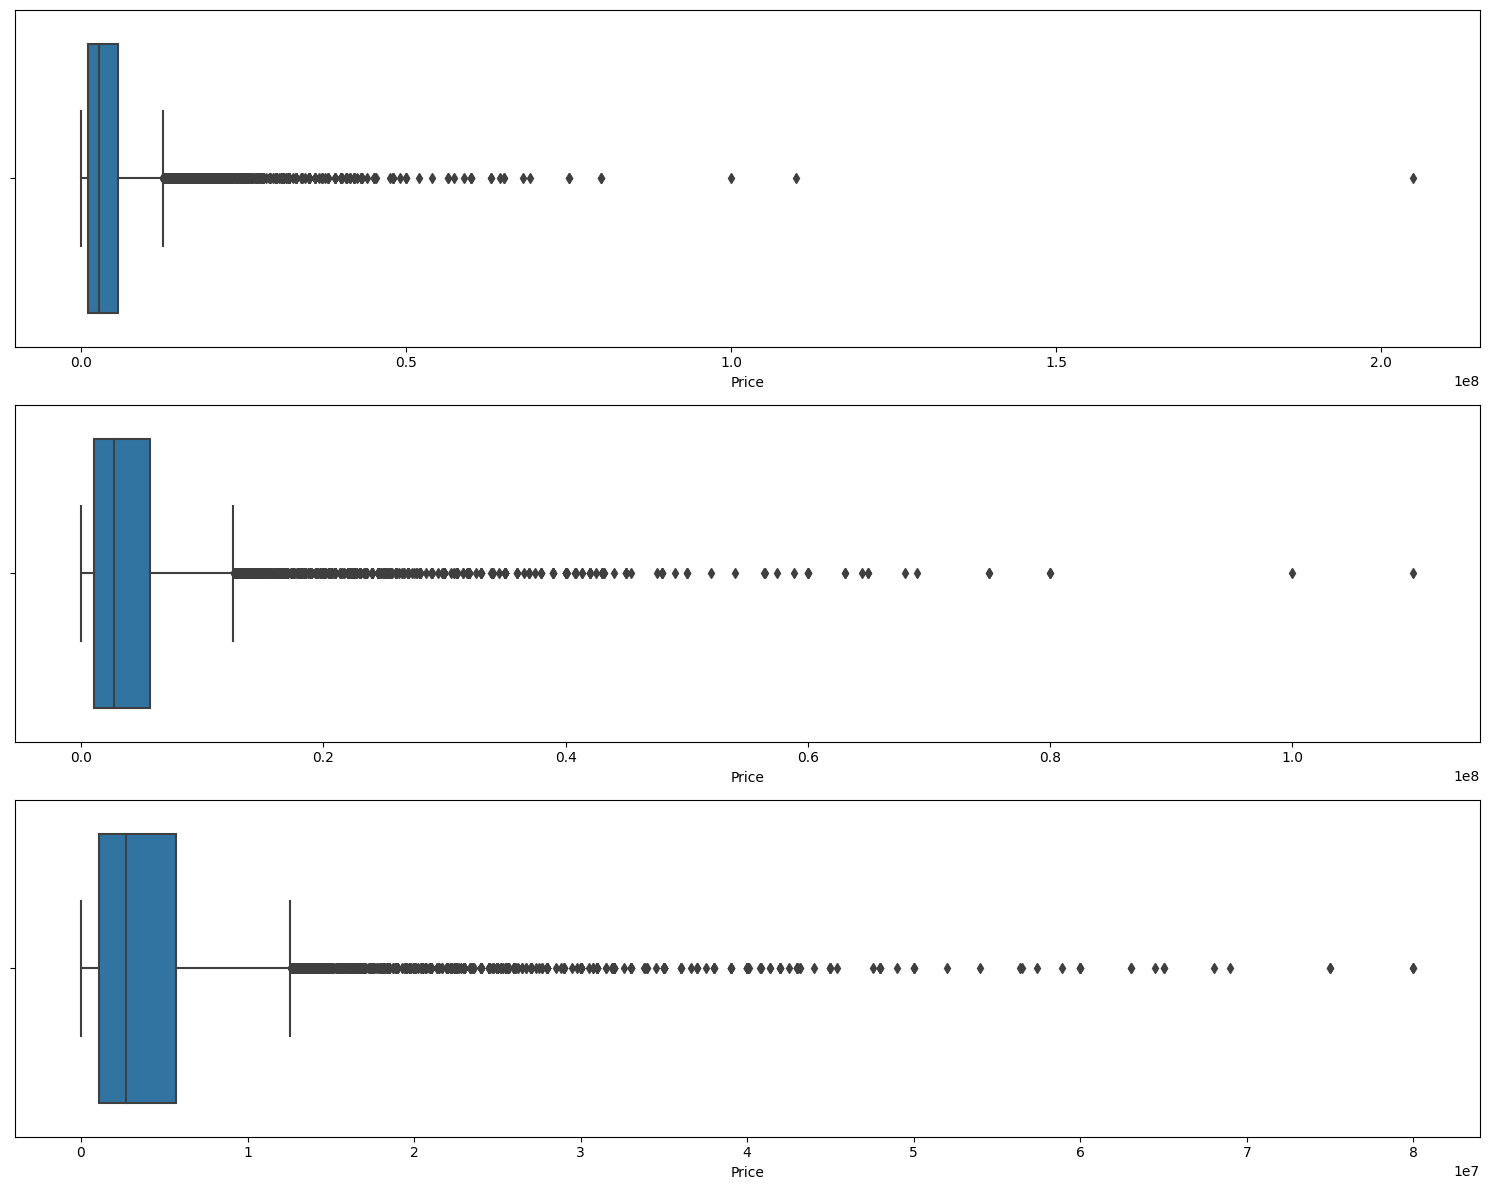

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3,1, figsize=(15,12))
sns.boxplot(x='Price', data=df, ax=axes[0])

sns.boxplot(x='Price', data=df[df['Price']<200000000], ax=axes[1])

sns.boxplot(x='Price', data=df[df['Price']<100000000], ax=axes[2])

plt.tight_layout()
plt.show()

Values >= 100,000,000 EGP will be removed

In [33]:
df = df[df['Price']<100000000]
df.shape

(24755, 12)

## Final Cleaned Data:

In [34]:
df.head(10)

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,Region
0,Duplex,4000000,3,3,400.0,No,7,No,Cash,Ready to Move,Finished,Cairo
2,Apartment,2250000,3,2,165.0,No,1,No,Cash,Ready to Move,Finished,Alexandria
3,Apartment,1900000,3,2,230.0,No,10,No,Cash,Ready to Move,Finished,Cairo
4,Apartment,5800000,2,3,160.0,No,Ground,Yes,Cash,Ready to Move,Not Finished,New Cairo
5,Apartment,1844900,4,3,222.0,No,1,Yes,Cash or Installment,Not ready to Move,Not Finished,New Cairo
6,Duplex,3900000,5,5,290.0,No,Highest,Yes,Unknown,Ready to Move,Finished,New Cairo
7,Apartment,1650000,2,2,144.0,No,1,Yes,Unknown,Ready to Move,Finished,Giza and Suburbs
8,Apartment,1560000,3,3,200.0,No,Ground,No,Unknown,Not ready to Move,Not Finished,New Cairo
9,Apartment,992800,3,2,146.0,No,3,No,Cash or Installment,Not ready to Move,Not Finished,New Cairo
10,Apartment,309825,4,3,153.0,No,1,Yes,Cash or Installment,Not ready to Move,Not Finished,New Cairo


In [35]:
df.shape

(24755, 12)

In [36]:
df.to_csv('cleaned_egy_house_prices.csv', index=False)

# 2 - EXPLORATORY DATA ANALYSIS

## 2.1 - Descriptive Statistics

In [37]:
pd.set_option('display.float_format', '{:.2f}'.format)
summary = df.describe()
summary

,Price,Bedrooms,Bathrooms,Area
count,24755.00,24755.00,24755.00,24755.00
mean,4424736.96,3.21,2.77,228.24
std,5439730.78,1.16,1.29,158.18
min,30000.00,1.00,1.00,10.00
25%,1100000.00,3.00,2.00,125.00
50%,2700000.00,3.00,3.00,176.00
75%,5688000.00,4.00,3.00,272.50
max,80000000.00,10.00,10.00,995.00


In [38]:
df[df['Area']<50]

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,Region
608,Studio,1250000,1,1,42.00,Yes,Ground,No,Cash,Ready to Move,Finished,New Cairo
813,Studio,800000,1,1,34.00,No,Ground,Yes,Cash or Installment,Not ready to Move,Finished,Giza and Suburbs
985,Apartment,1296000,1,1,36.00,Yes,9,No,Cash or Installment,Not ready to Move,Finished,New Cities
1853,Apartment,1291500,2,1,41.00,No,4,No,Installment,Not ready to Move,Finished,New Cities
2280,Apartment,3200000,4,1,20.00,No,4,No,Cash or Installment,Not ready to Move,Finished,New Cities
...,...,...,...,...,...,...,...,...,...,...,...,...
20363,Stand Alone Villa,6000000,4,3,44.00,No,Unknown,No,Unknown,Not ready to Move,Unknown,Giza and Suburbs
20727,Town House,6500000,3,3,44.00,No,Unknown,No,Unknown,Not ready to Move,Unknown,Giza and Suburbs
20728,Town House,8100000,3,3,44.00,No,Unknown,No,Unknown,Not ready to Move,Unknown,Giza and Suburbs
24905,Stand Alone Villa,29000000,5,6,11.00,No,Unknown,Yes,Cash,Ready to Move,Not Finished,New Cairo


In [39]:
df[df['Price']<100000]

,Type,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Payment_Option,Delivery_Date,Delivery_Term,Region
157,Apartment,36000,3,2,161.00,No,2,No,Cash or Installment,Ready to Move,Unknown,New Cairo
1627,Apartment,90000,2,2,115.00,No,5,No,Cash or Installment,Not ready to Move,Not Finished,Cairo
2009,Apartment,91000,2,1,92.00,No,2,Yes,Installment,Not ready to Move,Unknown,New Cairo
2010,Apartment,87000,2,1,112.00,No,Ground,Yes,Installment,Not ready to Move,Not Finished,New Cities
2125,Apartment,50000,2,1,65.00,No,2,No,Cash or Installment,Not ready to Move,Finished,North Coast
...,...,...,...,...,...,...,...,...,...,...,...,...
18210,Chalet,99000,2,2,100.00,Yes,Ground,Yes,Cash,Not ready to Move,Unknown,Red Sea
18697,Twin House,50000,3,2,209.00,No,Unknown,No,Cash,Ready to Move,Not Finished,New Cities
19574,Stand Alone Villa,95000,5,3,265.00,No,Unknown,No,Cash or Installment,Not ready to Move,Not Finished,New Cairo
20933,Stand Alone Villa,50000,7,4,950.00,No,Unknown,No,Cash or Installment,Not ready to Move,Finished,Upper Egypt


This data does not seem fully correct & realistic, there are many trends + observations that do not make sense (e.g. 36000 EGP for chalet on the North Coast)

It is not the case where anomolous observations may be removed; doing so would eliminate a large chunk of data

**Check percentiles as well**

In [40]:
df.quantile(0.9, numeric_only = True)

Price       10440000.00
Bedrooms           5.00
Bathrooms          4.00
Area             433.60
Name: 0.9, dtype: float64

90% of the data:
- <10.4M EGP
- <5 bedrooms
- <4 bathrooms
- <434m^2 area

In [41]:
df.quantile(0.95, numeric_only = True)

Price       14500000.00
Bedrooms           5.00
Bathrooms          5.00
Area             600.00
Name: 0.95, dtype: float64

In [42]:
IQR = summary.loc['75%'] - summary.loc['25%']
Upper_Bound = summary.loc['75%'] + 1.5*IQR
Lower_Bound = summary.loc['25%'] - 1.5*IQR

summary.loc['IQR'] = IQR
summary.loc['Lower_Bound'] = Lower_Bound
summary.loc['Upper_Bound'] = Upper_Bound

summary

,Price,Bedrooms,Bathrooms,Area
count,24755.00,24755.00,24755.00,24755.00
mean,4424736.96,3.21,2.77,228.24
std,5439730.78,1.16,1.29,158.18
min,30000.00,1.00,1.00,10.00
25%,1100000.00,3.00,2.00,125.00
50%,2700000.00,3.00,3.00,176.00
75%,5688000.00,4.00,3.00,272.50
max,80000000.00,10.00,10.00,995.00
IQR,4588000.00,1.00,1.00,147.50
Lower_Bound,-5782000.00,1.50,0.50,-96.25


In [43]:
summary.loc['Lower_Bound', 'Price'] = 0
summary.loc['Lower_Bound', 'Area'] = 0

summary

,Price,Bedrooms,Bathrooms,Area
count,24755.00,24755.00,24755.00,24755.00
mean,4424736.96,3.21,2.77,228.24
std,5439730.78,1.16,1.29,158.18
min,30000.00,1.00,1.00,10.00
25%,1100000.00,3.00,2.00,125.00
50%,2700000.00,3.00,3.00,176.00
75%,5688000.00,4.00,3.00,272.50
max,80000000.00,10.00,10.00,995.00
IQR,4588000.00,1.00,1.00,147.50
Lower_Bound,0.00,1.50,0.50,0.00


Check for extreme outliers for Price & Area (larger values):

In [44]:
summary.loc['75%']['Price'] + 3*summary.loc['IQR']['Price']

19452000.0

Insights:

- 1 bedroom is considered an outlier, however this is probably due to a class-imbalance of not many 'Studios' present
- 5+ bathrooms & 6+ bedrooms are also considered anomolous, however this is probably also due to a class-imbalance of larger properties being underepresented in comparison to other property types

**Properties having a price greater than 12.5M EGP is considered anomolous here**

***A property having a price greater than 19.5M EGP is considered an extreme outlier here*** - this is likely due to class imbalances of not as many high-end properties being present in this dataset, **Therefore, one cannot consider these as outliers, since the property type is likely to have an impact on price, as will be explored in later**

In [45]:
df[df['Price']>12573750].shape

(1718, 12)

## 2.2 - Data Distribution

### Price

<Axes: xlabel='Price'>

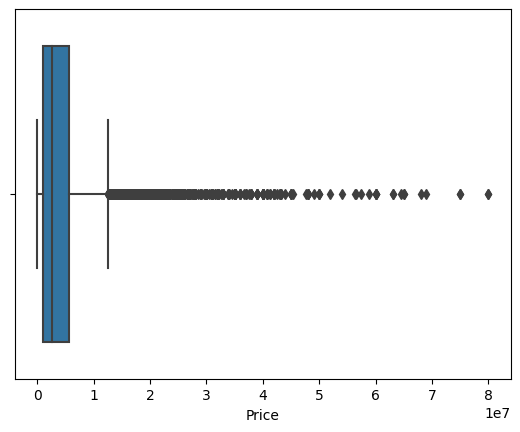

In [46]:
sns.boxplot(x='Price', data=df)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Count'>

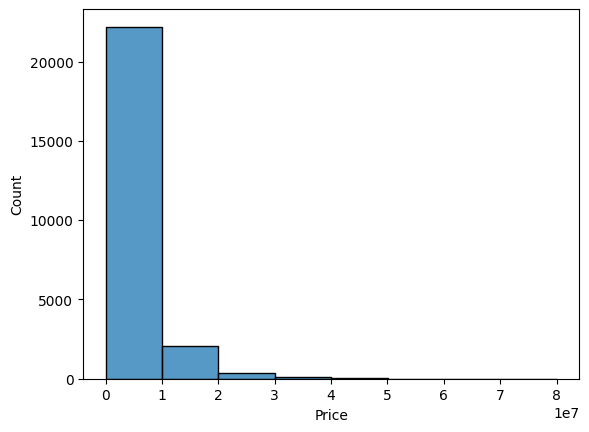

In [47]:
sns.histplot(x='Price', data=df, bins=8)

Clear Right-Skew:

VAST Majority of property prices are less than 10M EGP

### Bedrooms & Bathrooms

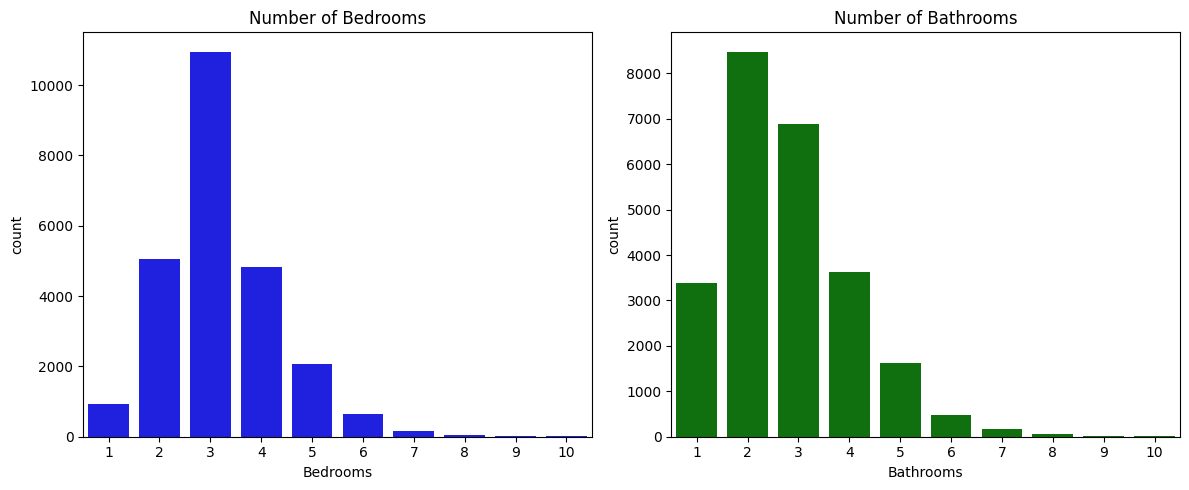

In [48]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.countplot(data=df, x='Bedrooms', ax=axes[0], color='blue')
axes[0].set_title('Number of Bedrooms')

sns.countplot(data=df, x='Bathrooms', ax=axes[1], color='green')
axes[1].set_title('Number of Bathrooms')

plt.tight_layout()
plt.show()

### Area

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Area', ylabel='Count'>

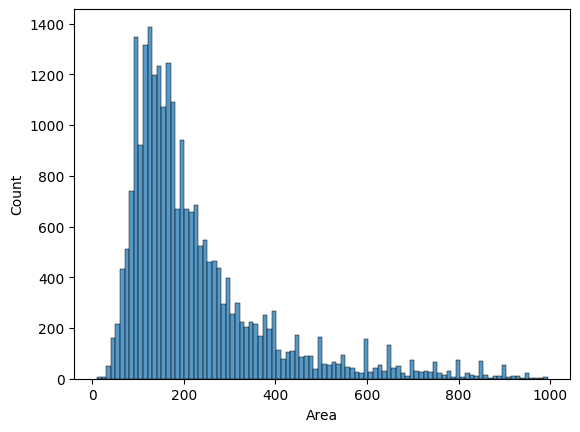

In [49]:
sns.histplot(x='Area', data=df)

Area is more normally distributed, however also having a positive skew

### (Property) Type

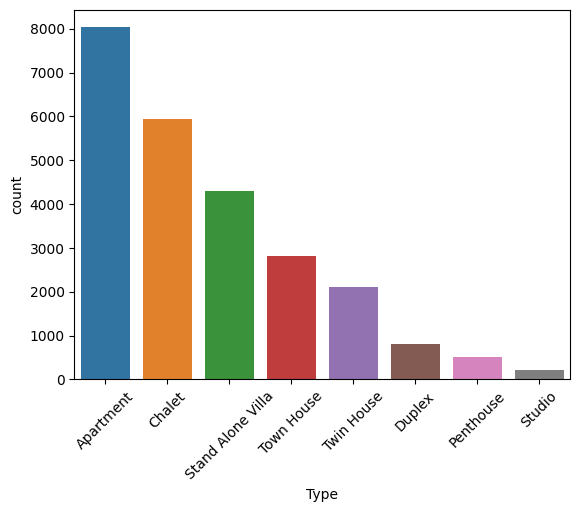

In [50]:
sns.countplot(x='Type', data=df, order=df['Type'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='Price', ylabel='Type'>

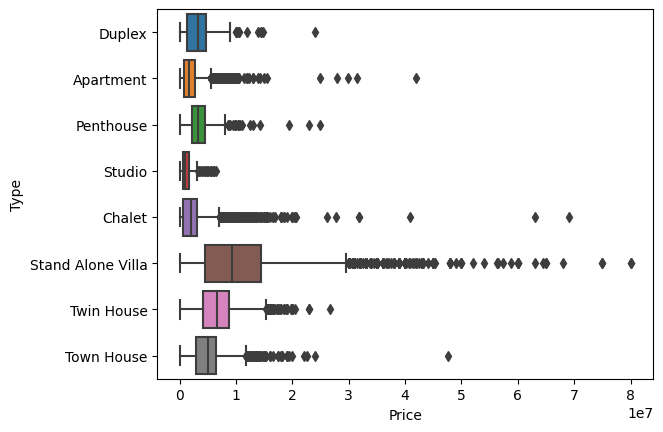

In [51]:
sns.boxplot(x='Price', y='Type', data=df)

Clearly the property type has an effect on the price

Some outliers for certain types exist, these *could* be removed

### Furnished

<Axes: xlabel='Furnished', ylabel='Price'>

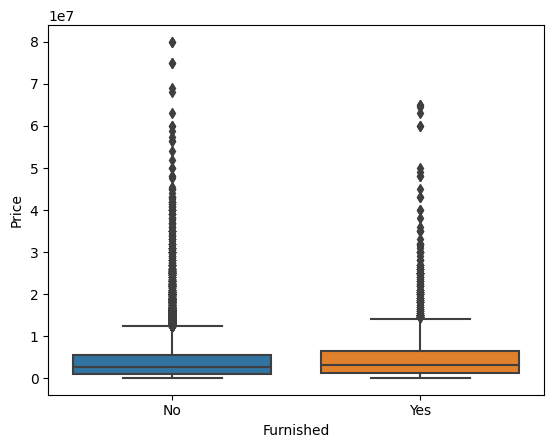

In [52]:
sns.boxplot(x='Furnished', y='Price', data=df)

No strong correlation, however it does make sense that furnished properties may have properties if the buyer chooses to purchase the property with the furniture - increasing the price

In [53]:
df['Furnished'].value_counts()

Furnished
No     22657
Yes     2098
Name: count, dtype: int64

Either way, there is a **huge class imbalance** for this variable

### Level:

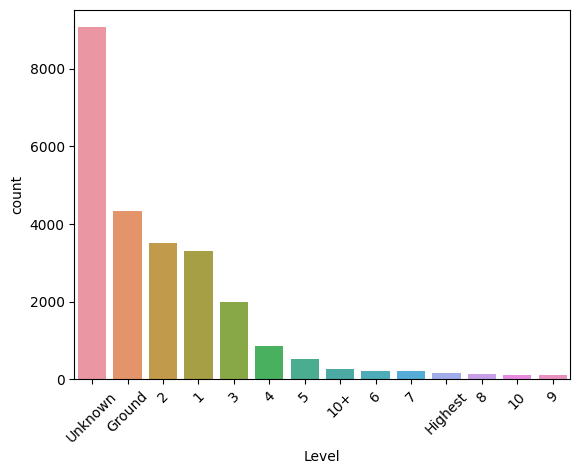

In [54]:
sns.countplot(x='Level', data=df, order=df['Level'].value_counts().index)
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='Price', ylabel='Level'>

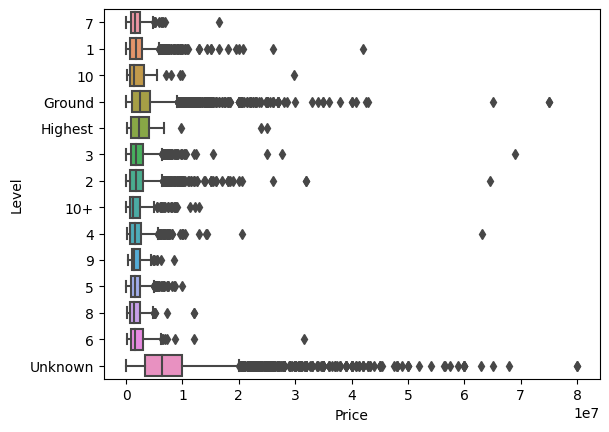

In [55]:
sns.boxplot(x='Price', y='Level', data=df)

'Unknown' standing out may be due to the fact that it contains various types of properties.

Level will naturally correlate with the Type of property

In [56]:
df['Level'].value_counts()

Level
Unknown    9065
Ground     4334
2          3502
1          3315
3          1981
4           858
5           523
10+         253
6           217
7           206
Highest     169
8           126
10          103
9           103
Name: count, dtype: int64

### Payment Option

<Axes: xlabel='Payment_Option', ylabel='count'>

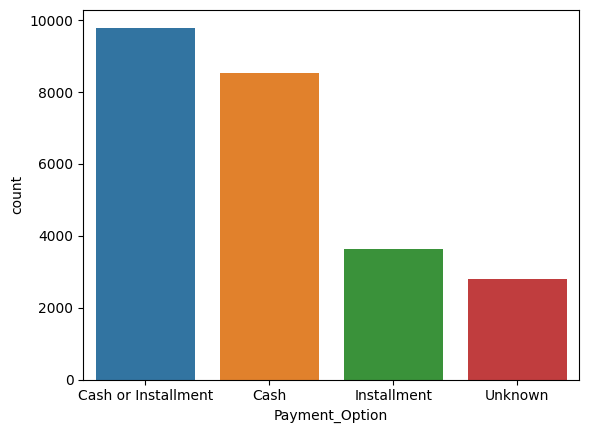

In [57]:
sns.countplot(x='Payment_Option', data=df, order=df['Payment_Option'].value_counts().index)

<Axes: xlabel='Price', ylabel='Payment_Option'>

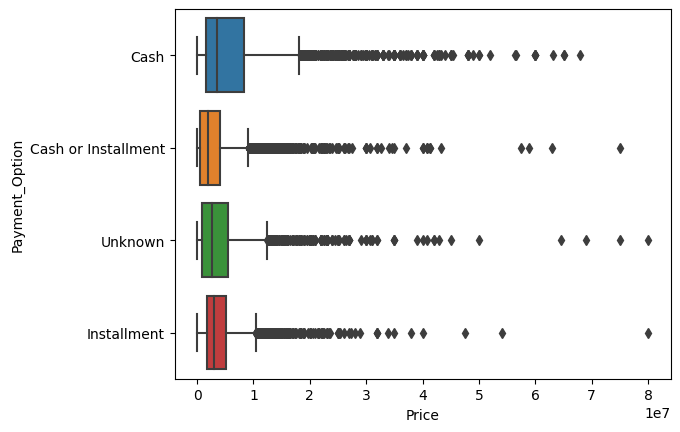

In [58]:
sns.boxplot(x='Price', y='Payment_Option', data=df)

Counter-intuitive: Usually 'Cash' has discounts.
This may be due to a correlation between 'Payment_Option' and 'Type', whereby in this dataset, the *high-end properties are mostly paid for by cash*

In [59]:
pd.crosstab(index=df['Payment_Option'], columns=df['Type'])

Type,Apartment,Chalet,Duplex,Penthouse,Stand Alone Villa,Studio,Town House,Twin House
Payment_Option,,,,,,,,
Cash,3303,1168,297,189,2034,60,595,894
Cash or Installment,2850,3134,323,182,1285,103,1300,618
Installment,1142,934,109,78,433,34,568,327
Unknown,734,710,84,54,555,27,360,271


In [60]:
pd.crosstab(index=df['Payment_Option'], columns=df['Type'], normalize='index')*100

Type,Apartment,Chalet,Duplex,Penthouse,Stand Alone Villa,Studio,Town House,Twin House
Payment_Option,,,,,,,,
Cash,38.68,13.68,3.48,2.21,23.82,0.70,6.97,10.47
Cash or Installment,29.10,32.00,3.30,1.86,13.12,1.05,13.27,6.31
Installment,31.50,25.77,3.01,2.15,11.94,0.94,15.67,9.02
Unknown,26.26,25.40,3.01,1.93,19.86,0.97,12.88,9.70


A higher percentage of 'cash' payments are made on 'stand alone villas' which, referring to a previous boxplot by property type, have relatively high prices

### Delivery_Date

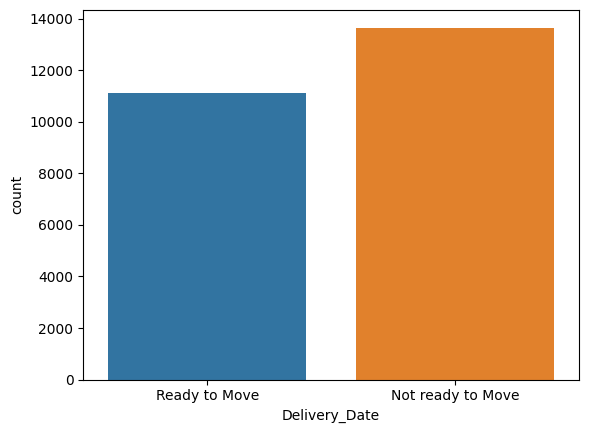

In [61]:
sns.countplot(x='Delivery_Date', data=df);

<Axes: xlabel='Price', ylabel='Delivery_Date'>

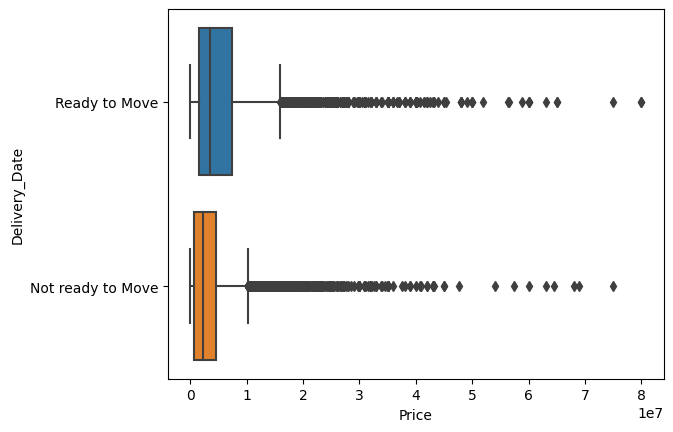

In [62]:
sns.boxplot(x='Price', y='Delivery_Date', data=df)

It is evident that a house being 'Ready to Move' will jack up the price

### Delivery_Term

<Axes: xlabel='Delivery_Term', ylabel='count'>

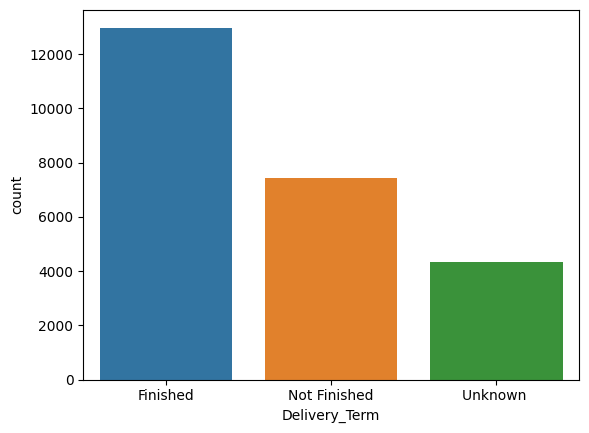

In [63]:
sns.countplot(x='Delivery_Term', data=df)

<Axes: xlabel='Price', ylabel='Delivery_Term'>

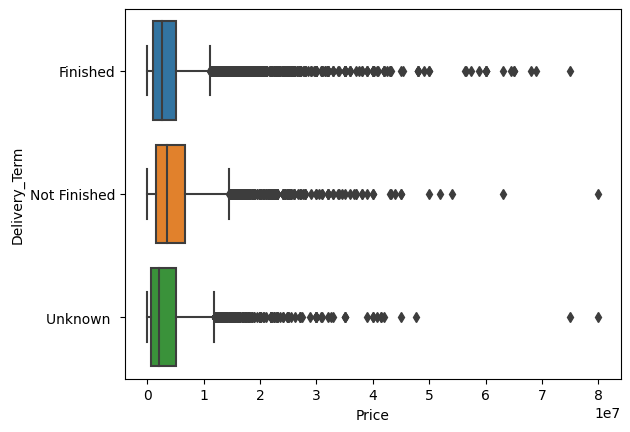

In [64]:
sns.boxplot(x='Price', y='Delivery_Term', data=df)

Counter-intuitive: 'Not Finished' houses have the highest prices

**This may be due to the coincidence that higher-end properties are mostly unfinished**

### Region

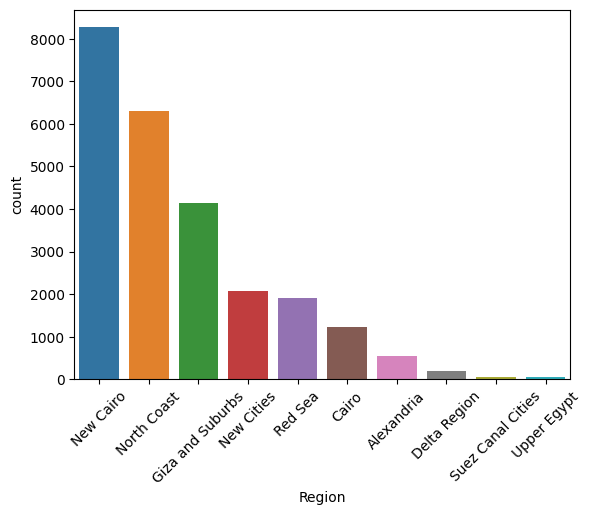

In [65]:
sns.countplot(x='Region', data=df, order=df['Region'].value_counts().index);
plt.xticks(rotation=45);

*Delta Region, Suez Canal Cities & Upper Egypt may be put in an 'other' category*

<Axes: xlabel='Price', ylabel='Region'>

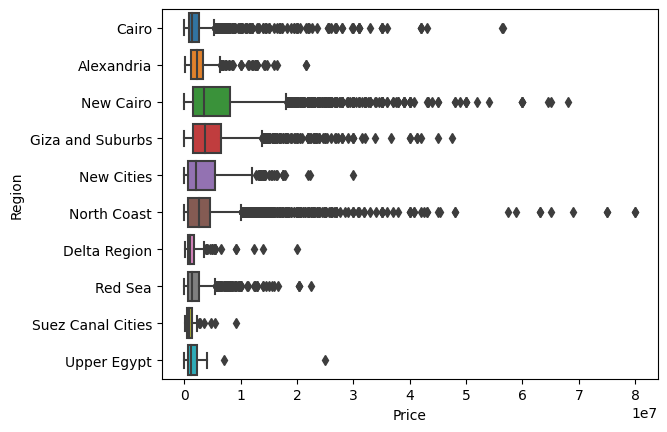

In [66]:
sns.boxplot(x='Price',y='Region',data=df)

In [67]:
pd.crosstab(index=df['Region'], columns=df['Type'], normalize='index')*100

Type,Apartment,Chalet,Duplex,Penthouse,Stand Alone Villa,Studio,Town House,Twin House
Region,,,,,,,,
Alexandria,86.06,5.20,1.30,0.19,4.28,0.74,1.67,0.56
Cairo,78.42,3.48,2.43,1.05,9.05,0.81,3.40,1.37
Delta Region,81.63,3.06,3.57,0.00,5.10,0.00,6.12,0.51
Giza and Suburbs,41.67,1.45,3.93,1.95,22.04,0.39,15.58,13.00
New Cairo,41.66,1.39,4.17,2.16,25.60,0.76,13.49,10.76
New Cities,47.02,0.29,4.70,0.73,16.97,0.44,21.23,8.63
North Coast,2.65,66.05,2.16,2.73,10.33,1.20,8.27,6.61
Red Sea,2.89,79.43,1.42,2.21,6.31,2.42,1.95,3.37
Suez Canal Cities,72.55,19.61,0.00,0.00,5.88,0.00,0.00,1.96


## 2.3 - Correlations & Relationships

### Numeric Features

<Axes: xlabel='Bedrooms', ylabel='Price'>

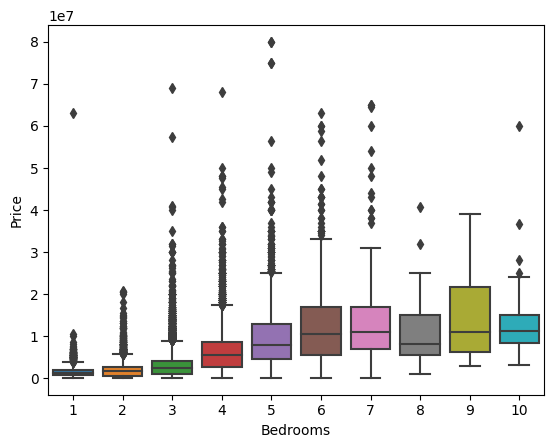

In [68]:
sns.boxplot(x='Bedrooms', y='Price', data=df)

<Axes: xlabel='Area', ylabel='Price'>

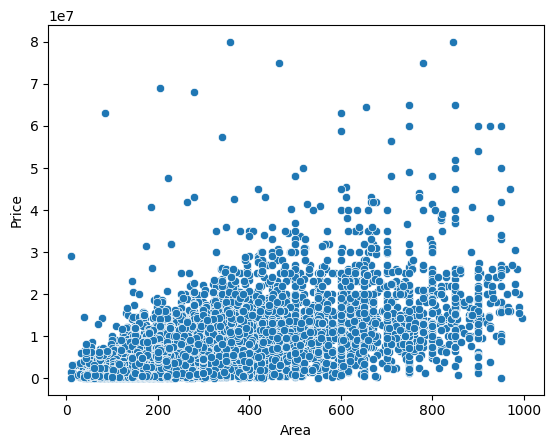

In [69]:
sns.scatterplot(x='Area', y = 'Price', data=df)

<Axes: xlabel='Area', ylabel='Price'>

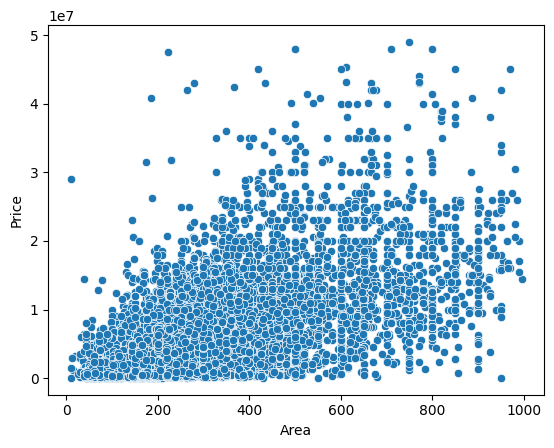

In [70]:
sns.scatterplot(x='Area', y = 'Price', data=df[df['Price']<50000000])

### Correlogram

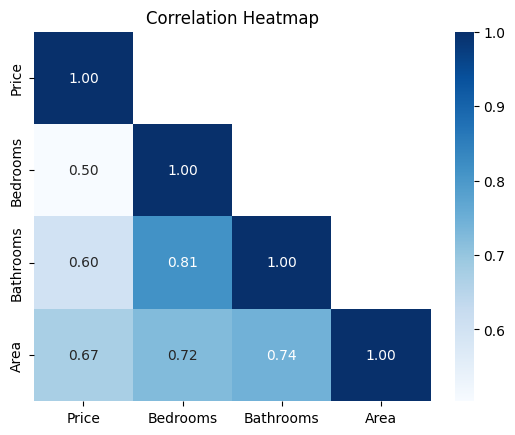

In [71]:
mask = np.triu(np.ones_like(df.corr(method='pearson', numeric_only=True), dtype=bool), k=1)

sns.heatmap(df.corr(method='pearson', numeric_only=True), mask=mask, cmap='Blues', annot=True, fmt=".2f");
plt.title('Correlation Heatmap');

### F-tests (Numeric Features)

In [72]:
numeric_features.remove('Price')

In [73]:
from sklearn.feature_selection import f_classif

f_scores, p_values = f_classif(df[numeric_features], df['Price'])

for col, f_score in zip(numeric_features, f_scores):
    print(f"Feature: {col}, F-score: {f_score}")

Feature: Bedrooms, F-score: 4.304331616362991
Feature: Bathrooms, F-score: 6.457130508242621
Feature: Area, F-score: 7.994133762822415


Bedrooms - Moderate relationship with Price

Bathrooms - Stronger realtionship with Price

Area - Highly Significant relationship with Price

*All 3 can be used, however 1 or 2 may be removed to prevent multicollinearity.*
For now:

- Drop Bedrooms
- Keep Bathrooms (consider dropping latter)

### ANOVA Tests (Categorical Features)

In [74]:
from scipy.stats import f_oneway

for col in categorical_features:
    groups = [df['Price'][df[col] == value] for value in df[col].unique()]
    f_stat, p_value = f_oneway(*groups)
    #if p_value < 0.05:
    #    selected_features.append(col)

    print(f"Feature: {col}, F-statistic: {f_stat}, P-value: {p_value}")

Feature: Type, F-statistic: 1946.7667827613482, P-value: 0.0
Feature: Furnished, F-statistic: 94.01216597022517, P-value: 3.434403540724669e-22
Feature: Level, F-statistic: 532.7457294825206, P-value: 0.0
Feature: Payment_Option, F-statistic: 523.5543878310081, P-value: 0.0
Feature: Delivery_Date, F-statistic: 912.5729976901117, P-value: 6.791417440138143e-197
Feature: Delivery_Term, F-statistic: 82.1832735195833, P-value: 2.668344657528658e-36
Feature: Compound, F-statistic: 1457.9049637323033, P-value: 5.3029466184941e-310
Feature: Region, F-statistic: 169.307095552088, P-value: 6.9036170545e-313


Since F-statistics are inflated for large datasets, Mutual Information (MI) scores can be used instead:

- Caputres non-linear relationships
- Doesn't assume normality or linear dependencies (unlike ANOVA)

In [75]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

encoded_features = df[categorical_features].apply(LabelEncoder().fit_transform)

mi_scores = mutual_info_regression(encoded_features, df['Price'])

mi_df = pd.DataFrame({'Feature': categorical_features, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values(by='MI_Score', ascending=False)

# Display results
print(mi_df)

          Feature  MI_Score
0            Type      0.30
2           Level      0.17
7          Region      0.16
3  Payment_Option      0.15
4   Delivery_Date      0.08
5   Delivery_Term      0.07
6        Compound      0.07
1       Furnished      0.02


### Chi-Squared Tests (Categorical Features)

In [76]:
categorical_features

['Type',
 'Furnished',
 'Level',
 'Payment_Option',
 'Delivery_Date',
 'Delivery_Term',
 'Compound',
 'Region']

In [77]:
from scipy.stats import chi2_contingency
import itertools

chi2_results = []

for col1, col2 in itertools.combinations(categorical_features, 2):

    contingency_table = pd.crosstab(df[col1], df[col2])
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chi2_results.append({
        'Variable 1': col1,
        'Variable 2': col2,
        'Chi2': chi2,
        'p-value': p,
        'Dependent': p < 0.05
    })

chi2_results_df = pd.DataFrame(chi2_results)
pd.set_option('display.float_format', '{:.2f}'.format)

chi2_results_df

,Variable 1,Variable 2,Chi2,p-value,Dependent
0,Type,Furnished,884.03,0.00,True
1,Type,Level,24484.41,0.00,True
2,Type,Payment_Option,1546.11,0.00,True
3,Type,Delivery_Date,1411.36,0.00,True
4,Type,Delivery_Term,3973.73,0.00,True
5,Type,Compound,1297.36,0.00,True
6,Type,Region,16727.17,0.00,True
7,Furnished,Level,213.17,0.00,True
8,Furnished,Payment_Option,1146.54,0.00,True
9,Furnished,Delivery_Date,519.23,0.00,True


Large Datasets *inflate p-values* so a different measure: **Cramér's V** can be used instead

Implementing Cramér's V:

In [78]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(r - 1, k - 1))

results = []
for col1, col2 in itertools.combinations(categorical_features, 2):
    cramers_v_value = cramers_v(df[col1], df[col2])
    results.append({
        'Variable 1': col1,
        'Variable 2': col2,
        'Cramer\'s V': cramers_v_value
    })

cramers_v_df = pd.DataFrame(results)

cramers_v_df = cramers_v_df.sort_values(by="Cramer's V", ascending=False)

cramers_v_df

,Variable 1,Variable 2,Cramer's V
18,Payment_Option,Delivery_Date,0.50
1,Type,Level,0.38
26,Delivery_Term,Region,0.32
6,Type,Region,0.31
4,Type,Delivery_Term,0.28
27,Compound,Region,0.25
3,Type,Delivery_Date,0.24
24,Delivery_Date,Region,0.24
12,Furnished,Region,0.23
5,Type,Compound,0.23


# 3 - FEATURE ENGINEERING

## 3.1 - Provisional Feature Selection + Encoding

Provisional Features Selected:

- Area
- Type
- Delivery Date
- Compound (binary variable whether property is in a compound or not)
- *consider including Region, (despite multicollinearity)*
- *consider including one of bedrooms/bathrooms*

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("/kaggle/input/clean-house-prices/cleaned_egy_house_prices.csv")

#Scaling Area
scaler = StandardScaler()
df.loc[:,'Area'] = scaler.fit_transform(df[['Area']])

#One-Hot-Encoding:
mult_categories = ['Type', 'Payment_Option', 'Region']
encoder = OneHotEncoder(drop='first', sparse=False)

for cat in mult_categories:
    encoded = encoder.fit_transform(df[[cat]])
    columns = encoder.get_feature_names_out([cat])
    
    df_encoded = pd.DataFrame(np.hstack([encoded]), columns=np.concatenate([columns]))
    df = pd.concat([df, df_encoded], axis=1)
    df.drop([cat], axis=1, inplace=True)

df.drop('Unnamed: 0', axis=1, inplace=True)

#Binary Mapping:
df['Delivery_Date'] = df['Delivery_Date'].map({'Not ready to Move': 0, 'Ready to Move': 1})
df['Compound'] = df['Compound'].map({'No': 0, 'Yes': 1})
df['Furnished'] = df['Furnished'].map({'No': 0, 'Yes': 1})

#Ordinal Encoding:
df['Level'] = df['Level'].replace({'Unknown':-1, 'Ground':0, '10+':11, 'Highest':12})
df['Level'] = df['Level'].astype(int)
df['Delivery_Term'] = df['Delivery_Term'].map({'Unknown':-1, 'Not Finished':0, 'Finished':1})

df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Price,Bedrooms,Bathrooms,Area,Furnished,Level,Compound,Delivery_Date,Delivery_Term,Type_Chalet,Type_Duplex,Type_Penthouse,Type_Stand Alone Villa,Type_Studio,Type_Town House,Type_Twin House,Payment_Option_Cash or Installment,Payment_Option_Installment,Payment_Option_Unknown,Region_Cairo,Region_Delta Region,Region_Giza and Suburbs,Region_New Cairo,Region_New Cities,Region_North Coast,Region_Red Sea,Region_Suez Canal Cities,Region_Upper Egypt
0,4000000,3,3,1.09,0,7,0,1,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2250000,3,2,-0.40,0,1,0,1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1900000,3,2,0.01,0,10,0,1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,5800000,2,3,-0.43,0,0,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
4,1844900,4,3,-0.04,0,1,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


### Exporting Encoded DataFrame (for Streamlit app):

In [80]:
df.to_csv("encoded_data_for_model.csv", index=False)

In [81]:
#selected_features = ['Price', 'Type', 'Area', 'Delivery_Date', 'Compound', 'Region', 'Bathrooms']

df_m1 = df.drop(['Bedrooms', 'Furnished', 'Level', 'Delivery_Term'], axis=1)
df_m1.head()

,Price,Bathrooms,Area,Compound,Delivery_Date,Type_Chalet,Type_Duplex,Type_Penthouse,Type_Stand Alone Villa,Type_Studio,Type_Town House,Type_Twin House,Payment_Option_Cash or Installment,Payment_Option_Installment,Payment_Option_Unknown,Region_Cairo,Region_Delta Region,Region_Giza and Suburbs,Region_New Cairo,Region_New Cities,Region_North Coast,Region_Red Sea,Region_Suez Canal Cities,Region_Upper Egypt
0,4000000,3,1.09,0,1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2250000,2,-0.40,0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,1900000,2,0.01,0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,5800000,3,-0.43,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
4,1844900,3,-0.04,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00


In [82]:
df_m1.shape

(24755, 24)

# 4 - MODEL BUILDING

## 4.1 - Linear Regression

In [83]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df_m1.drop('Price', axis=1)
y = df_m1['Price']

print(X.shape, y.shape)

(24755, 23) (24755,)


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [85]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 14904727612868.76
R-squared: 0.5180693329226551


## 4.2 - XGBoost

In [86]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 14233291012686.78
R-squared: 0.539779618211362


In [87]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='r2', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Best R-squared: 0.5908557575031586


## Passing in All Features:

In [88]:
X = df.drop('Price', axis=1)
y = df['Price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 13091684071373.764
R-squared: 0.5766924293044065


In [89]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='r2', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}
Best R-squared: 0.6098827315046099


In [90]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 12399921064199.375
R-squared: 0.5990599502793716


# FINAL MODEL (to be exported)

In [91]:
import pickle

with open('/kaggle/working/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)